In [1]:
import pandas as pd
import numpy as np
import DataPrep
import error_evaluation

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, Input
from keras.layers import Bidirectional
from keras import optimizers
from keras.models import Model
from keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler, Normalizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Using TensorFlow backend.


In [ ]:
%%javascript
var kernel = Jupyter.notebook.kernel
kernel.execute('kernel_name = ' + '"' + kernel.name + '"')

In [ ]:
print(kernel_name)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
from azureml.core import Workspace
from azureml.core import Experiment
ws = Workspace.get('scottchamlworkspace', subscription_id='7d2d1e21-7718-415a-b98e-780ef0b02ad5', resource_group='mlworkspacerg')
ws.write_config()

In [ ]:
exp = Experiment(workspace=ws, name='lightgbm-exp1')

In [3]:
dp = DataPrep.DataPrep()
X_test, X_train, y_test, y_train = dp.prep_timeseries_train_test(input_file='E:/Data/OAPMLData/V1.1_CAIC_UAC_NWAC_FeaturesAsTimeSeries20131101To20180430.csv', ignore_extreme=True, test_is_most_recent_season = True, only_critical_points=False, oversample=False, only_precise_points = False, label_critical_points=True, coastal_or_contenental='both', date_features=False, region_features=False, print_df=False)


test shape: (99256, 47)


C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
np.save('E:/Temp/X_test_noextrafeatures.npy', X_test)
np.save('E:/Temp/X_train_noextrafeatures.npy', X_train)
y_test.to_csv('E:/Temp/y_test_noextrafeatures.csv', index=False)
y_train.to_csv('E:/Temp/y_train_noextrafeatures.csv', index=False)

In [ ]:
X_train.shape


In [ ]:
y_test['__fileDate'].value_counts()

In [ ]:
y_train['o_Day1DangerAboveTreeline'].value_counts()

In [2]:
X_test = np.load('E:/Temp/X_test_noextrafeatures.npy')
X_train = np.load('E:/Temp/X_train_noextrafeatures.npy')

In [3]:
y_test = pd.read_csv('E:/Temp/y_test_noextrafeatures.csv', parse_dates=True)
y_train = pd.read_csv('E:/Temp/y_train_noextrafeatures.csv', parse_dates=True)

In [4]:

y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
synthetic_regions = ['Low West', 'Low East', 'In The Desert', 'In The Lake']
X_test = X_test[~y_test['UnifiedRegion'].isin(synthetic_regions)]
X_train = X_train[~y_train['UnifiedRegion'].isin(synthetic_regions)]
y_test = y_test[~y_test['UnifiedRegion'].isin(synthetic_regions)]
y_train = y_train[~y_train['UnifiedRegion'].isin(synthetic_regions)]
y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [ ]:
y_train['o_Day1DangerAboveTreeline'].value_counts()

In [5]:
y_train_cat = to_categorical(y_train[['o_Day1DangerAboveTreeline', 'o_Day1DangerNearTreeline','o_Day1DangerBelowTreeline']])
y_test_cat = to_categorical(y_test[['o_Day1DangerAboveTreeline', 'o_Day1DangerNearTreeline','o_Day1DangerBelowTreeline']])

In [ ]:
y_train_cat.shape

In [ ]:
y_train.shape

In [ ]:
X_train.shape

In [ ]:
y_train_cat[:,0,:]

In [ ]:
from sklearn.utils import class_weight
class_weights = list()
class_weights.append(class_weight.compute_class_weight('balanced', np.unique(y_train['o_Day1DangerAboveTreeline']), y_train['o_Day1DangerAboveTreeline'].values))
class_weights.append(class_weight.compute_class_weight('balanced', np.unique(y_train['o_Day1DangerNearTreeline']), y_train['o_Day1DangerNearTreeline'].values))
class_weights.append(class_weight.compute_class_weight('balanced', np.unique(y_train['o_Day1DangerBelowTreeline']), y_train['o_Day1DangerBelowTreeline'].values))

In [ ]:
class_weights

In [ ]:
y_train['o_Day1DangerAboveTreeline'].value_counts()

In [ ]:
y_train_moderate[:10].index.values, y_train_moderate[:10].index.values

In [ ]:
y_train_low = y_train[y_train['o_Day1DangerAboveTreeline']==0]
y_train_moderate = y_train[y_train['o_Day1DangerAboveTreeline']==1]
y_train_considerable = y_train[y_train['o_Day1DangerAboveTreeline']==2]
y_train_high = y_train[y_train['o_Day1DangerAboveTreeline']==3]

In [ ]:
y_train_low.sample(n=10, random_state=1)

In [ ]:
tmp = np.vstack((X_train[y_train_moderate[:10].index.values], X_train[y_train_moderate[10:20].index.values])).shape

In [ ]:
amount_per_class = int(32/4)
y_train_batch = pd.concat([y_train_low.sample(n=amount_per_class, random_state=1), 
                           y_train_moderate[0:0+amount_per_class],
                           y_train_considerable.sample(n=amount_per_class, random_state=1), 
                           y_train_high.sample(n=amount_per_class, random_state=1)])#.sample(frac=1, random_state=1)
y_train_batch_cat = to_categorical(y_train_batch[['o_Day1DangerAboveTreeline', 'o_Day1DangerNearTreeline','o_Day1DangerBelowTreeline']])
X_train_batch = X_train[y_train_batch.index.values]

In [ ]:
y_train_high.index.values

In [ ]:
X_train[y_train_batch.index.values]

In [ ]:
seq = AvySequenceProportional(X_train, y_train, 768)

In [ ]:
tmpx, tmpy = seq.__getitem__(2)

In [ ]:
seq.__len__()

In [ ]:
tmpy.shape

In [ ]:
y_train_batch_cat = to_categorical(y_train_batch[['o_Day1DangerAboveTreeline', 'o_Day1DangerNearTreeline','o_Day1DangerBelowTreeline']])

In [ ]:
tmpx, tmpy = seq.__getitem__(256)

In [ ]:
tmpy.shape

In [6]:


class AvySequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.y_train_low = y_set[y_set['o_Day1DangerAboveTreeline']==0]
        self.y_train_moderate = y_set[y_set['o_Day1DangerAboveTreeline']==1]
        self.y_train_considerable = y_set[y_set['o_Day1DangerAboveTreeline']==2]
        self.y_train_high = y_set[y_set['o_Day1DangerAboveTreeline']==3]
        self.amount_per_class = int(batch_size/4)
        
    def __len__(self):
        return int(len(self.y_train_moderate)/(self.batch_size/self.amount_per_class))
    
    def __getitem__(self, idx):
        start = idx*self.amount_per_class
        y_train_batch = pd.concat([self.y_train_low.sample(n=self.amount_per_class, random_state=idx), 
                                   #self.y_train_moderate[start:start+self.amount_per_class],    
                                   self.y_train_moderate.sample(n=self.amount_per_class, random_state=idx),  
                                   self.y_train_considerable.sample(n=self.amount_per_class, random_state=idx), 
                                   self.y_train_high.sample(n=self.amount_per_class, random_state=idx)]).sample(frac=1, random_state=idx) #sample causes the rows to shuffle
        y_train_batch_cat = to_categorical(y_train_batch[['o_Day1DangerAboveTreeline', 'o_Day1DangerNearTreeline','o_Day1DangerBelowTreeline']])
        X_train_batch = self.x[y_train_batch.index.values]
        return X_train_batch, y_train_batch_cat[:, 0,:].copy()  #copy required to make C_Contiguous values

class AvySequenceProportional(AvySequence):
    def __init__(self, x_set, y_set, batch_size):
        super().__init__(x_set, y_set, batch_size)
        
        #proportions Low 3/10, Mod 4/10, Con 2/10, High 1/10        
        self.prop_low = round(.3 * self.batch_size)
        self.prop_mod = round(.4 * self.batch_size)
        self.prop_con = round(.2 * self.batch_size)
        self.prop_high = round(.1 * self.batch_size)
        
    def __len__(self):
        return int(len(self.y_train_moderate)/(self.batch_size/self.prop_mod))
    
    def __getitem__(self, idx):
        
        
        start = idx*self.prop_mod
        y_train_batch = pd.concat([self.y_train_low.sample(n=self.prop_low, random_state=idx), 
                                   self.y_train_moderate[start:start+self.prop_mod],                                   
                                   self.y_train_considerable.sample(n=self.prop_con, random_state=idx), 
                                   self.y_train_high.sample(n=self.prop_high, random_state=idx)]).sample(frac=1, random_state=idx) #sample causes the rows to shuffle
        y_train_batch_cat = to_categorical(y_train_batch[['o_Day1DangerAboveTreeline', 'o_Day1DangerNearTreeline','o_Day1DangerBelowTreeline']])
        X_train_batch = self.x[y_train_batch.index.values]
        return X_train_batch, y_train_batch_cat[:, 0,:].copy() 
        
def generate_balanced_batches(X_train, y_train, batch_size=32):
    while True: #loop indefinitely
        y_train_low = y_train[y_train['o_Day1DangerAboveTreeline']==0]
        y_train_moderate = y_train[y_train['o_Day1DangerAboveTreeline']==1]
        y_train_considerable = y_train[y_train['o_Day1DangerAboveTreeline']==2]
        y_train_high = y_train[y_train['o_Day1DangerAboveTreeline']==3]
        amount_per_class = int(batch_size/4)
        for i in range(0, len(y_train_moderate), amount_per_class): #get total amount of moderate forcasts and generate 1/4 of a batch containing those
            y_train_batch = pd.concat([y_train_low.sample(n=amount_per_class, random_state=i), 
                                       y_train_moderate[i:amount_per_class],
                                       y_train_considerable.sample(n=amount_per_class, random_state=i), 
                                       y_train_high.sample(n=amount_per_class, random_state=i)]).sample(frac=1, random_state=i) #sample causes the rows to shuffle
            y_train_batch_cat = to_categorical(y_train_batch[['o_Day1DangerAboveTreeline', 'o_Day1DangerNearTreeline','o_Day1DangerBelowTreeline']])
            X_train_batch = X_train[y_train_batch.index.values]
            yield(X_train_batch, y_train_batch_cat[:, 0,:])
               

In [ ]:
run = exp.start_logging()
run.log(name="Model Type", value="Keras")
run.log(name="Imbalance Correction", value="Per Batch Random Sampling")
run.log(name="Amount of Lookback", value="Full Season")
run.log(name="Feature Pruning", value="No Dates")

In [10]:
# fit and evaluate a model
def evaluate_model_basic(trainX, trainy, testX, testy, b_size=512):
    verbose, epochs, batch_size = 1, 1, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(32, input_shape=(n_timesteps,n_features)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model

In [11]:
# fit and evaluate a model
def evaluate_model_basic128(trainX, trainy, testX, testy, b_size=512):
    verbose, epochs, batch_size = 1, 1, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps,n_features)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model

In [42]:
# fit and evaluate a model
def evaluate_model_basic128(trainX, trainy, testX, testy, b_size=512, e=1):
    verbose, epochs, batch_size = 1, e, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps,n_features)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [52]:
def evaluate_model_basic_x(trainX, trainy, testX, testy, b_size=512, e=1, depth=128):
    verbose, epochs, batch_size = 2, e, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(depth, input_shape=(n_timesteps,n_features)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [28]:
def evaluate_model_basic_lower_learn_x(trainX, trainy, testX, testy, b_size=512, e=1, depth=128):
    verbose, epochs, batch_size = 2, e, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(depth, input_shape=(n_timesteps,n_features)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_hinge', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [64]:
def evaluate_model_basic_bi_x(trainX, trainy, testX, testy, b_size=512, e=1, depth=128):
    verbose, epochs, batch_size = 2, e, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Bidirectional(LSTM(depth), input_shape=(n_timesteps,n_features)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [7]:
def evaluate_model_basic_2_x(trainX, trainy, testX, testy, b_size=512, e=1, depth=128):
    verbose, epochs, batch_size = 2, e, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(depth, input_shape=(n_timesteps,n_features), return_sequences=True))
    model.add(LSTM(int(depth/2)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [8]:
def evaluate_model_basic_2_dropout_x(trainX, trainy, testX, testy, b_size=512, e=1, depth=128):
    verbose, epochs, batch_size = 2, e, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(depth, input_shape=(n_timesteps,n_features), return_sequences=True))
    model.add(Dropout(.25))
    model.add(LSTM(int(depth/2)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [12]:
def evaluate_model_basic_3_x(trainX, trainy, testX, testy, b_size=512, e=1, depth=128):
    verbose, epochs, batch_size = 2, e, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(depth, input_shape=(n_timesteps,n_features), return_sequences=True))    
    model.add(LSTM(int(depth/2), return_sequences=True))
    model.add(LSTM(depth))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [14]:
def evaluate_model_basic_3_dropout_x(trainX, trainy, testX, testy, b_size=512, e=1, depth=128):
    verbose, epochs, batch_size = 2, 5, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(depth, input_shape=(n_timesteps,n_features), return_sequences=True))
    model.add(Dropout(.25))
    model.add(LSTM(int(depth/2), return_sequences=True))
    model.add(Dropout(.25))
    model.add(LSTM(depth))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [33]:
def evaluate_model_basic_3d_x(trainX, trainy, testX, testy, b_size=512, e=1, depth=128):
    verbose, epochs, batch_size = 2, 3, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(depth, input_shape=(n_timesteps,n_features), return_sequences=True))    
    model.add(LSTM(int(depth/2), return_sequences=True))
    model.add(LSTM(depth))
    model.add(Dense(int(depth/2), activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    history = model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, history

In [ ]:

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 2, 1, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_timesteps,n_features)))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    #model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, validation_data = (testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=class_weights[0])
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model

In [ ]:
int(len(y_train[y_train['o_Day1DangerAboveTreeline']==1])/(32/8))

In [ ]:
int(32/4)

In [ ]:
len(y_train[y_train['o_Day1DangerAboveTreeline']==1])/8

In [ ]:

# fit and evaluate a model
def evaluate_model_balanced(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 2, 1, 768
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_timesteps,n_features)))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    # fit network
    steps = int(len(y_train[y_train['o_Day1DangerAboveTreeline']==1])/(batch_size/4))
    #training_generator = generate_balanced_batches(trainX, trainy, batch_size=batch_size)
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
                        #use_multiprocessing=True, workers=2)
    #model.fit(trainX, trainy, validation_data = (testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=class_weights[0])
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model

In [ ]:
def evaluate_model_balanced2(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 2, 1, 768
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64), input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    # fit network
    steps = int(len(y_train[y_train['o_Day1DangerAboveTreeline']==1])/(batch_size/4))
    #training_generator = generate_balanced_batches(trainX, trainy, batch_size=batch_size)
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
                        #use_multiprocessing=True, workers=2)
    #model.fit(trainX, trainy, validation_data = (testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=class_weights[0])
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model

In [ ]:
def evaluate_model2(trainX, trainy, testX, testy, b_size=3074):
    # define model
    verbose, epochs, batch_size = 2, 3, b_size
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 5, 30
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=15, activation='relu'), input_shape=(n_steps,n_length,n_features)))
    #model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    #model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy',  optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    print('Model config:' + str(model.get_config()))
    # fit network
    #model.fit(trainX, trainy, validation_data = (testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=class_weights[0])
    seq = AvySequence(trainX, trainy, batch_size=batch_size)
    model.fit_generator(generator=seq, validation_data = (testX, testy[:, 0,:]), 
                        epochs=epochs, verbose=verbose, shuffle=True)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy[:, 0,:], batch_size=batch_size, verbose=0)
    return accuracy, model, testX, testy

In [ ]:
def evaluate_model3(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 2, 25, 128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 5, 30
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [ ]:
# fit and evaluate a model
def evaluate_model4(trainX, trainy, testX, testy):
    
    verbose, epochs, batch_size = 2, 10, 128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
   
    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_timesteps,n_features)))
    model.add(Bidirectional(LSTM(n_features, return_sequences=True)))
    model.add(TimeDistributed(Dense(n_features)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(n_features*2)))
    model.add(Dropout(0.5))
    model.add(Dense(n_features, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, validation_data = (testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=class_weights)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model
    
    
  #  model = Sequential()
  #  model.add(BatchNormalization(input_shape=(n_timesteps,n_features)))
  #  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  #  model.add(TimeDistributed(Dense(n_features)))
  #  model.add(BatchNormalization())
  #  
  #  model.add(Bidirectional(LSTM(2*128, return_sequences=True)))
  #  model.add(TimeDistributed(Dense(2*128)))
  #  model.add(Dropout(.2))
  #  model.add(BatchNormalization())
  #  
  #  model.add(Bidirectional(LSTM(3*128, return_sequences=True)))
  #  model.add(TimeDistributed(Dense(3*128)))
  #  model.add(Dropout(.3))
  #  model.add(BatchNormalization())
              
  #  model.add(Bidirectional(LSTM(2*128, return_sequences=True)))
  #  model.add(TimeDistributed(Dense(2*128)))
  #  model.add(Dropout(.4))

              
    #model.add((LSTM(128)))
    #model.add(TimeDistributed(Dense(128)))
    #model.add(BatchNormalization())
              
  #  model.add(Dense(n_features, activation='relu'))
  #  model.add(Dense(n_outputs, activation='softmax'))
  #  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   # print(model.summary())
    # fit network
   # model.fit(trainX, trainy, validation_data = (testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=class_weights)
    # evaluate model
    #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    #return accuracy

In [ ]:
def evaluate_model5(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 2, 10, 128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    batchSize = 128
    return_sequences_val = True
    print("Create Model")
    #model = Sequential()
    input_data = Input(shape=(n_timesteps,n_features), name="input_data")
    lstm1 = Bidirectional(LSTM(64, return_sequences=return_sequences_val), merge_mode="sum")(input_data)
    dense1 = TimeDistributed(Dense(64))(lstm1)
    norm1 = BatchNormalization()(dense1)
    #drop1 = Dropout(.1)(norm1)
    
    lstm2 = Bidirectional(LSTM(128, return_sequences=return_sequences_val))(norm1)
    dense2 = Dense(128)(lstm2)
    drop2 = Dropout(.2)(dense2)
    norm2 = BatchNormalization()(drop2)


    lstm3 = Bidirectional(LSTM(256, return_sequences=return_sequences_val))(norm2)
    dense3 = Dense(256)(lstm3)
    drop3 = Dropout(.3)(dense3)
    

    lstm4 = Bidirectional(LSTM(128, return_sequences=return_sequences_val))(norm3)
    dense4 = Dense(128)(lstm4)
    drop4 = Dropout(.4)(dense4)
    norm4 = BatchNormalization()(drop4)

    lstm5 = Bidirectional(LSTM(64))(norm4)
    dense5 = Dense(64)(lstm5)
    norm5 = BatchNormalization()(dense5)
    #drop5 = Dropout(.4)(norm5)

    out1 = Dense(4, activation='softmax', name="above_danger")(norm5)
    out2 = Dense(4, activation='softmax', name="near_danger")(norm5)
    out3 = Dense(4, activation='softmax', name="below_danger")(norm5)

    model = Model(inputs=[input_data], outputs=[out1, out2, out3])


    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=["accuracy"])
    # fit network
    model.fit(trainX, [trainy[:, 0,:], trainy[:, 1,:], trainy[:,2,:]], validation_data = (testX, [testy[:, 0,:], testy[:, 1,:], testy[:,2,:]]), epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, [testy[:, 0,:], testy[:, 1,:], testy[:,2,:]], batch_size=batch_size, verbose=0)
    return accuracy, model

In [ ]:
def evaluate_model6(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 2, 10, 128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    return_sequences_val = True
    print("Create Model")
   
    input_data = Input(shape=(n_timesteps,n_features), name="input_data")
     
    lstm1 = Bidirectional(LSTM(n_features, return_sequences=return_sequences_val))(input_data)
   #drop1 = TimeDistributed(Dropout(.1))(lstm1)
    lstm2 = Bidirectional(LSTM(2*n_features, return_sequences=return_sequences_val))(lstm1)
    #norm3 = BatchNormalization()(lstm2)
    drop2 = Dropout(.25)(lstm2)
    
    #norm4 = BatchNormalization()(dense1)
    lstm3 = Bidirectional(LSTM(n_features))(drop2)
    lstm4 = Bidirectional(LSTM(n_features))(drop2)
    lstm5 = Bidirectional(LSTM(n_features))(drop2)

    dense1 = Dense(n_features, activation='relu')(lstm3)
    dense2 = Dense(n_features, activation='relu')(lstm4)
    dense3 = Dense(n_features, activation='relu')(lstm5)
    
    out1 = Dense(4, activation='softmax', name="above_danger")(dense1)
    out2 = Dense(4, activation='softmax', name="near_danger")(dense2)
    out3 = Dense(4, activation='softmax', name="below_danger")(dense3)

    model = Model(inputs=[input_data], outputs=[out1, out2, out3])


    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=["accuracy"])
    # fit network
    model.fit(trainX, [trainy[:, 0,:], trainy[:, 1,:], trainy[:,2,:]], validation_data = (testX, [testy[:, 0,:], testy[:, 1,:], testy[:,2,:]]), epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, [testy[:, 0,:], testy[:, 1,:], testy[:,2,:]], batch_size=batch_size, verbose=0)
    return accuracy, model

In [ ]:
def evaluate_model7(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 2, 2, 128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    return_sequences_val = True
    print("Create Model")
   
    input_data = Input(shape=(n_timesteps,n_features), name="input_data")
     
    lstm1 = Bidirectional(LSTM(128, return_sequences=False))(input_data)
    #lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
    #lstm3 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
    #lstm4 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
    
    #lstm5 = Bidirectional(LSTM(32, return_sequences=False))(lstm2)
    #lstm6 = Bidirectional(LSTM(32, return_sequences=False))(lstm3)
    #lstm7 = Bidirectional(LSTM(32, return_sequences=False))(lstm4)
    #drop2 = Dropout(.25)(lstm2)
    #drop3 = Dropout(.25)(lstm3)
    #drop4 = Dropout(.25)(lstm4)
    
    #dense1 = Dense(64, activation='relu')(drop2)
    #dense2 = Dense(64, activation='relu')(drop3)
    #dense3 = Dense(64, activation='relu')(drop4)
    
    out1 = Dense(4, activation='softmax', name="above_danger")(lstm1)
    out2 = Dense(4, activation='softmax', name="near_danger")(lstm1)
    out3 = Dense(4, activation='softmax', name="below_danger")(lstm1)

    model = Model(inputs=[input_data], outputs=[out1, out2, out3])


    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=["accuracy"])
    # fit network
    model.fit(trainX, [trainy[:, 0,:], trainy[:, 1,:], trainy[:,2,:]], validation_data = (testX, [testy[:, 0,:], testy[:, 1,:], testy[:,2,:]]), epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=class_weights)
    # evaluate model
    #_, accuracy = model.evaluate(testX, [testy[:, 0,:], testy[:, 1,:], testy[:,2,:]], batch_size=batch_size, verbose=0)
    return model

In [ ]:
y_train[:1000]

In [67]:
from numpy import mean
from numpy import std
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

def run_experiment(max_depth):
    # repeat experiment
    scores = list()
    #reshaped_test_X = None
    #reshaped_test_y = None
    for r in [64, 128, 256, 512, 768, 1024, 2048]:
        print('Depth: ' + str(r))
        #score, model = evaluate_model_balanced(X_train, y_train_cat[:,0,:], X_test, y_test_cat[:,0,:])
        #model = evaluate_model7(X_train, y_train_cat, X_test, y_test_cat)
        model = evaluate_model_basic_2_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=r)
        #score = score * 100.0
        #print('>#%d: %.3f' % (r+1, score))
        #scores.append(score)
    # summarize results
    #summarize_results(scores)
    return model

In [56]:
#baisc
m = run_experiment(1024)

Depth: 64
Epoch 1/1
 - 689s - loss: 0.3069 - acc: 0.8782 - val_loss: 3.0342 - val_acc: 0.4848
Depth: 128
Epoch 1/1
 - 692s - loss: 0.4531 - acc: 0.8128 - val_loss: 2.1585 - val_acc: 0.4933
Depth: 192
Epoch 1/1
 - 684s - loss: 0.7699 - acc: 0.6736 - val_loss: 2.3340 - val_acc: 0.4721
Depth: 256
Epoch 1/1
 - 686s - loss: 0.4220 - acc: 0.8218 - val_loss: 4.1474 - val_acc: 0.4368
Depth: 320
Epoch 1/1
 - 676s - loss: 0.9462 - acc: 0.5812 - val_loss: 1.1022 - val_acc: 0.4682
Depth: 384
Epoch 1/1
 - 671s - loss: 1.2159 - acc: 0.4120 - val_loss: 1.2807 - val_acc: 0.3256
Depth: 448
Epoch 1/1
 - 687s - loss: 3.1618 - acc: 0.4533 - val_loss: 1.0773 - val_acc: 0.4780
Depth: 512
Epoch 1/1
 - 698s - loss: 0.9848 - acc: 0.5658 - val_loss: 1.0700 - val_acc: 0.4893
Depth: 576
Epoch 1/1
 - 906s - loss: 8.1865 - acc: 0.3676 - val_loss: 13.9863 - val_acc: 0.0626
Depth: 640
Epoch 1/1
 - 901s - loss: 1.1300 - acc: 0.4826 - val_loss: 0.9952 - val_acc: 0.4990
Depth: 704
Epoch 1/1
 - 901s - loss: 0.9396 - acc:

KeyboardInterrupt: 

In [65]:
#basic_bi
m = run_experiment(1024)

Depth: 64
Epoch 1/1
 - 1298s - loss: 0.4174 - acc: 0.8289 - val_loss: 2.9353 - val_acc: 0.4667
Depth: 128
Epoch 1/1
 - 1300s - loss: 0.3078 - acc: 0.8758 - val_loss: 1.8863 - val_acc: 0.4452
Depth: 256
Epoch 1/1
 - 1289s - loss: 0.2778 - acc: 0.8849 - val_loss: 6.9198 - val_acc: 0.4260
Depth: 512
Epoch 1/1
 - 1347s - loss: 0.3067 - acc: 0.8692 - val_loss: 2.9757 - val_acc: 0.4565
Depth: 768
Epoch 1/1
 - 2705s - loss: 1.0549 - acc: 0.5403 - val_loss: 1.3692 - val_acc: 0.2974
Depth: 1024
Epoch 1/1


KeyboardInterrupt: 

In [72]:
#basic 2
m = run_experiment(1024)

Depth: 64
Epoch 1/1
 - 1390s - loss: 0.2743 - acc: 0.8798 - val_loss: 4.3547 - val_acc: 0.4985
Depth: 128
Epoch 1/1
 - 1368s - loss: 1.3500 - acc: 0.2797 - val_loss: 1.3863 - val_acc: 0.4288
Depth: 256
Epoch 1/1
 - 1390s - loss: 1.0112 - acc: 0.5292 - val_loss: 0.9578 - val_acc: 0.5151
Depth: 512
Epoch 1/1
 - 1368s - loss: 1.0541 - acc: 0.4996 - val_loss: 1.5016 - val_acc: 0.0089
Depth: 768
Epoch 1/1
 - 1878s - loss: 1.3139 - acc: 0.3238 - val_loss: 1.4364 - val_acc: 0.0094
Depth: 1024
Epoch 1/1
 - 3703s - loss: 1.3384 - acc: 0.3176 - val_loss: 1.5002 - val_acc: 0.1376
Depth: 2048
Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[150,512,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training_38/Adam/gradients/lstm_51/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 (defined at C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:2519)  = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_38/Adam/gradients/lstm_51/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGrad/TensorArrayGradV3, lstm_51/TensorArrayUnstack/range, training_38/Adam/gradients/lstm_51/while/TensorArrayReadV3/Enter_1_grad/b_acc_3)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_38/Adam/gradients/lstm_51/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3', defined at:
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-72-cad5e51d48b3>", line 2, in <module>
    m = run_experiment(1024)
  File "<ipython-input-67-9caacf5939c3>", line 18, in run_experiment
    model = evaluate_model_basic_2_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=r)
  File "<ipython-input-71-8750007c4730>", line 12, in evaluate_model_basic_2_x
    epochs=epochs, verbose=verbose, shuffle=True)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\models.py", line 1315, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 2080, in fit_generator
    self._make_train_function()
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 992, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizers.py", line 445, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 2519, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 630, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 814, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 408, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 814, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\tensor_array_grad.py", line 187, in _TensorArrayScatterGrad
    grad = g.gather(indices)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\tensor_array_ops.py", line 873, in gather
    return self._implementation.gather(indices, name=name)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\tensor_array_ops.py", line 303, in gather
    element_shape=element_shape)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\gen_data_flow_ops.py", line 6031, in tensor_array_gather_v3
    flow_in=flow_in, dtype=dtype, element_shape=element_shape, name=name)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'lstm_51/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3', defined at:
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 27 identical lines from previous traceback]
  File "<ipython-input-67-9caacf5939c3>", line 18, in run_experiment
    model = evaluate_model_basic_2_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=r)
  File "<ipython-input-71-8750007c4730>", line 6, in evaluate_model_basic_2_x
    model.add(LSTM(int(depth/2)))
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\models.py", line 522, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\layers\recurrent.py", line 500, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\layers\recurrent.py", line 2112, in call
    initial_state=initial_state)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\layers\recurrent.py", line 609, in call
    input_length=timesteps)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 2695, in rnn
    input_ta = input_ta.unstack(inputs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 189, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\tensor_array_ops.py", line 907, in unstack
    return self._implementation.unstack(value, name=name)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 189, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\tensor_array_ops.py", line 331, in unstack
    indices=math_ops.range(0, num_elements), value=value, name=name)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 189, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\tensor_array_ops.py", line 347, in scatter
    name=name)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\gen_data_flow_ops.py", line 6690, in tensor_array_scatter_v3
    flow_in=flow_in, name=name)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[150,512,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training_38/Adam/gradients/lstm_51/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 (defined at C:\Users\scott\Anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:2519)  = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_38/Adam/gradients/lstm_51/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGrad/TensorArrayGradV3, lstm_51/TensorArrayUnstack/range, training_38/Adam/gradients/lstm_51/while/TensorArrayReadV3/Enter_1_grad/b_acc_3)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [10]:
for r in [64, 128, 256, 512]:
    print('Depth: ' + str(r))
    model = evaluate_model_basic_2_dropout_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=r)
    

Depth: 64
Epoch 1/1
 - 1352s - loss: 0.3462 - acc: 0.8612 - val_loss: 1.5565 - val_acc: 0.4486
Depth: 128
Epoch 1/1
 - 1356s - loss: 0.5405 - acc: 0.7647 - val_loss: 2.6793 - val_acc: 0.4860
Depth: 256
Epoch 1/1
 - 1370s - loss: 0.2702 - acc: 0.8823 - val_loss: 1.5249 - val_acc: 0.0089
Depth: 512
Epoch 1/1
 - 1449s - loss: 0.9677 - acc: 0.5564 - val_loss: 1.1266 - val_acc: 0.3428


In [13]:
for r in [64, 128, 256, 512]:
    print('Depth: ' + str(r))
    model = evaluate_model_basic_3_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=r)
    


Depth: 64
Epoch 1/1
 - 2360s - loss: 0.5060 - acc: 0.7733 - val_loss: 2.9723 - val_acc: 0.5359
Depth: 128
Epoch 1/1
 - 2288s - loss: 1.3121 - acc: 0.3284 - val_loss: 1.1078 - val_acc: 0.4159
Depth: 256
Epoch 1/1
 - 2186s - loss: 1.0585 - acc: 0.5022 - val_loss: 1.0909 - val_acc: 0.4500
Depth: 512
Epoch 1/1
 - 2515s - loss: 1.3316 - acc: 0.3207 - val_loss: 1.5154 - val_acc: 0.0089


In [15]:

model = evaluate_model_basic_3_dropout_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=64)


Epoch 1/5
 - 2630s - loss: 0.6698 - acc: 0.7045 - val_loss: 3.2080 - val_acc: 0.4652
Epoch 2/5
 - 2642s - loss: 0.2933 - acc: 0.8815 - val_loss: 6.3605 - val_acc: 0.4373
Epoch 3/5
 - 2639s - loss: 0.0795 - acc: 0.9718 - val_loss: 6.9473 - val_acc: 0.4404
Epoch 4/5
 - 2547s - loss: 0.4869 - acc: 0.7805 - val_loss: 1.5280 - val_acc: 0.2442
Epoch 5/5
 - 2411s - loss: 0.7251 - acc: 0.6847 - val_loss: 2.5093 - val_acc: 0.4198


In [22]:
for r in [64, 128, 256, 512]:
    print('Depth: ' + str(r))
    model = evaluate_model_basic_hinge_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=r)
    


Depth: 64
Epoch 1/1
 - 1075s - loss: 0.6740 - acc: 0.6561 - val_loss: 1.1472 - val_acc: 0.4042
Depth: 128
Epoch 1/1
 - 1060s - loss: 0.8183 - acc: 0.5601 - val_loss: 1.2616 - val_acc: 0.3526
Depth: 256
Epoch 1/1
 - 1076s - loss: 1.4397 - acc: 0.2728 - val_loss: 1.7270 - val_acc: 0.1365
Depth: 512
Epoch 1/1
 - 1073s - loss: 1.1349 - acc: 0.2984 - val_loss: 1.4018 - val_acc: 0.1375


In [29]:
for r in [64, 128, 256, 512]:
    print('Depth: ' + str(r))
    model = evaluate_model_basic_lower_learn_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=r)
    print("batch: 64")
    model2 = evaluate_model_basic_lower_learn_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=64, depth=r)
    



Depth: 64
Epoch 1/1
 - 1063s - loss: 0.9849 - acc: 0.4821 - val_loss: 1.0121 - val_acc: 0.3917
batch: 64
Epoch 1/1
 - 1042s - loss: 1.0056 - acc: 0.4588 - val_loss: 1.0050 - val_acc: 0.4446
Depth: 128
Epoch 1/1
 - 876s - loss: 0.9833 - acc: 0.4788 - val_loss: 0.9995 - val_acc: 0.4432
batch: 64
Epoch 1/1
 - 784s - loss: 0.9992 - acc: 0.4635 - val_loss: 0.9965 - val_acc: 0.4461
Depth: 256
Epoch 1/1
 - 1049s - loss: 0.9988 - acc: 0.4394 - val_loss: 1.0014 - val_acc: 0.4233
batch: 64
Epoch 1/1
 - 808s - loss: 1.0158 - acc: 0.3772 - val_loss: 1.0018 - val_acc: 0.3793
Depth: 512
Epoch 1/1
 - 1005s - loss: 0.9801 - acc: 0.4578 - val_loss: 1.0014 - val_acc: 0.4290
batch: 64
Epoch 1/1
 - 982s - loss: 1.0022 - acc: 0.4427 - val_loss: 1.0164 - val_acc: 0.3623


In [34]:
model = evaluate_model_basic_3d_x(X_train[:20000], y_train[:20000], X_test[:20000], y_test_cat[:20000], b_size=512, depth=64)



Epoch 1/3
 - 2891s - loss: 1.3646 - acc: 0.2683 - val_loss: 1.3863 - val_acc: 0.4288
Epoch 2/3
 - 2846s - loss: 1.3863 - acc: 0.2500 - val_loss: 1.3863 - val_acc: 0.4288
Epoch 3/3
 - 2852s - loss: 1.3863 - acc: 0.2500 - val_loss: 1.3863 - val_acc: 0.4288


In [ ]:
from keras.models import load_model
m = load_model('E:/Temp/model.h5')

In [35]:
m = model[1]

In [40]:
m = m[1]

TypeError: 'Sequential' object does not support indexing

In [ ]:
m.optimizer.lr = .01

In [ ]:
n_steps, n_length, n_features = 5, 30, 42
trainX = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
testX = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [34]:
seq = AvySequence(X_train, y_train, batch_size=512)
m.fit_generator(generator=seq, validation_data = (X_test, y_test_cat[:,0,:]), 
                epochs=1, verbose=2)

Epoch 1/1
 - 11110s - loss: 0.9843 - acc: 0.6195 - val_loss: 1.3369 - val_acc: 0.3069


In [ ]:


m.fit_generator(generator=seq, validation_data = (testX, y_test_cat[:,0,:]), 
                epochs=1, verbose=2)

In [ ]:
X_test=testX
X_train = trainX


In [ ]:
#training above here

In [ ]:
m.fit(X_train, [y_train_cat[:, 0,:], y_train_cat[:, 1,:], y_train_cat[:,2,:]], validation_data = (X_test, [y_test_cat[:, 0,:], y_test_cat[:, 1,:], y_test_cat[:,2,:]]), epochs=6, batch_size=128, verbose=2,  class_weight=class_weights)

In [ ]:
m.fit(X_train, [y_train_cat[:, 0,:], y_train_cat[:, 1,:], y_train_cat[:,2,:]], validation_data = (X_test, [y_test_cat[:, 0,:], y_test_cat[:, 1,:], y_test_cat[:,2,:]]), epochs=6, batch_size=128, verbose=2,  class_weight=class_weights)

In [ ]:
m.save(filepath='E:\Temp\model.h5')

In [ ]:
ret = m.predict(X_test[:100], batch_size=64)

In [15]:
y_test.head()

,o_Day1DangerAboveTreeline,o_Day1DangerNearTreeline,o_Day1DangerBelowTreeline,Lat,Lon,__fileDate,Season,UnifiedRegion,IsCriticalPoint
0,0,0,0,37.0448,-105.434,2017-11-30 00:00:00,17-18,Sangre de Cristo,False
1,0,0,0,37.0448,-105.434,2017-12-01 00:00:00,17-18,Sangre de Cristo,False
2,0,0,0,37.0448,-105.434,2017-12-02 00:00:00,17-18,Sangre de Cristo,False
3,0,0,0,37.0448,-105.434,2017-12-03 00:00:00,17-18,Sangre de Cristo,False
4,0,0,0,37.0448,-105.434,2017-12-04 00:00:00,17-18,Sangre de Cristo,False


In [36]:

y_train['o_Day1DangerAboveTreeline'] = pd.to_numeric(y_train['o_Day1DangerAboveTreeline'])
y_test['o_Day1DangerAboveTreeline'] = pd.to_numeric(y_test['o_Day1DangerAboveTreeline'])
def probability_to_prediction(prob):
    best_preds = [np.argmax(line) for line in prob]
    best_preds_df = pd.DataFrame(best_preds, columns=['o_Day1DangerAboveTreeline'])
    return best_preds_df

y_test = y_test.reset_index(drop=True)

#only look at critical points
y_test_crit = y_test[y_test['IsCriticalPoint']==True]
X_test_crit = X_test[y_test_crit.index, :, :]
preds_crit = m.predict(X_test_crit)

y_test = y_test.loc[:,~y_test.columns.duplicated()]

#split in to forecast types
#y_test_cont = y_test[y_test['c_IsContenentalSnowpack']==True]
#X_test_cont = X_test[y_test_cont.index.values, :, :]
#preds_cont2 = m.predict(X_test_cont, batch_size=64)

#y_test_coast = y_test[y_test['c_IsCoastalSnowpack']==True]
#X_test_coast = X_test[y_test_coast.index.values, :, :]
#preds_coast2 = m.predict(X_test_coast, batch_size=64)

ret = m.predict(X_test, batch_size=64)
preds = probability_to_prediction(ret)
#preds_coast = probability_to_prediction(preds_coast2)
#preds_cont = probability_to_prediction(preds_cont2)

Accuracy: 0.4149
Classification Report
              precision    recall  f1-score   support

           0       0.41      1.00      0.59      4149
           1       0.00      0.00      0.00      4144
           2       0.00      0.00      0.00      1524
           3       0.00      0.00      0.00       183

   micro avg       0.41      0.41      0.41     10000
   macro avg       0.10      0.25      0.15     10000
weighted avg       0.17      0.41      0.24     10000

Normalized confusion matrix
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

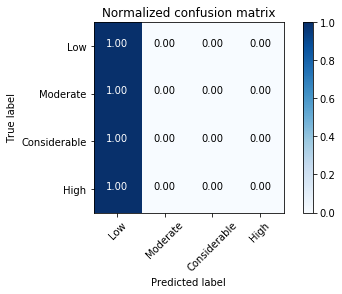

<Figure size 432x288 with 0 Axes>

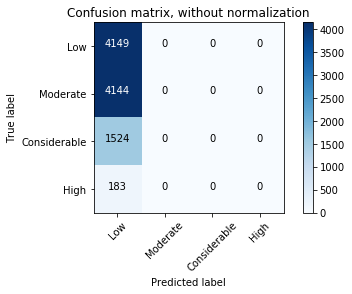

<Figure size 432x288 with 0 Axes>

In [37]:
import DataPrep
preds_train = probability_to_prediction(m.predict(X_train[:10000], batch_size=64))

report_all = error_evaluation.evaluateSingleClassShort(y_train['o_Day1DangerAboveTreeline'][:10000], preds_train['o_Day1DangerAboveTreeline'].values)
cnf_matrix = confusion_matrix(y_train['o_Day1DangerAboveTreeline'][:10000], preds_train)
plt.figure()
figure_all_norm = error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
figure_all = error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Confusion matrix, without normalization')
plt.figure()

Accuracy: 0.19816932431184794
Classification Report
              precision    recall  f1-score   support

           0       0.20      1.00      0.33     15025
           1       0.00      0.00      0.00     37793
           2       0.00      0.00      0.00     19815
           3       0.00      0.00      0.00      3186

   micro avg       0.20      0.20      0.20     75819
   macro avg       0.05      0.25      0.08     75819
weighted avg       0.04      0.20      0.07     75819

Normalized confusion matrix
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

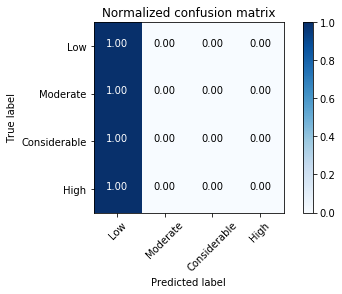

<Figure size 432x288 with 0 Axes>

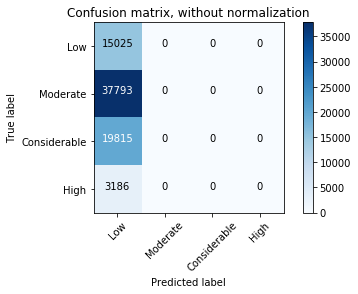

<Figure size 432x288 with 0 Axes>

In [38]:

report_all = error_evaluation.evaluateSingleClassShort(y_test['o_Day1DangerAboveTreeline'], preds)
cnf_matrix = confusion_matrix(y_test['o_Day1DangerAboveTreeline'], preds)
plt.figure()
figure_all_norm = error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
figure_all = error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Confusion matrix, without normalization')
plt.figure()
#cnf_matrix_crit = confusion_matrix(y_test_crit['o_Day1DangerAboveTreeline'], preds_crit)
#
#figure_crit_norm  = error_evaluation.plot_confusion_matrix(cnf_matrix_crit, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
#                      title='Critcial Point Normalized confusion matrix')
#plt.figure()
#figure_crit = error_evaluation.plot_confusion_matrix(cnf_matrix_crit, classes=['Low', 'Moderate', 'Considerable', 'High'],
#                      title='Critcial Point Confusion matrix, without normalization')
#plt.figure()

plt.show()

In [20]:
report_cont = error_evaluation.evaluateSingleClassShort(y_test_cont['o_Day1DangerAboveTreeline'], preds_cont)

cnf_matrix_cont = confusion_matrix(y_test_cont['o_Day1DangerAboveTreeline'], preds_cont)

figure_cont_norm = error_evaluation.plot_confusion_matrix(cnf_matrix_cont, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Contenental Forecast Normalized confusion matrix')
plt.figure()
figure_cont = error_evaluation.plot_confusion_matrix(cnf_matrix_cont, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Contenental Forecast Confusion matrix, without normalization')

plt.figure()
report_coast = error_evaluation.evaluateSingleClassShort(y_test_coast['o_Day1DangerAboveTreeline'], preds_coast)

cnf_matrix_coast = confusion_matrix(y_test_coast['o_Day1DangerAboveTreeline'], preds_coast)

figure_coast_norm = error_evaluation.plot_confusion_matrix(cnf_matrix_coast, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Coastal Forecast Normalized confusion matrix')
plt.figure()
figure_coast = error_evaluation.plot_confusion_matrix(cnf_matrix_coast, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Coastal Forecast Confusion matrix, without normalization')
plt.show()

NameError: name 'y_test_cont' is not defined

In [ ]:
preds.shape

In [ ]:
y_test['o_Day1DangerAboveTreeline'].shape

In [ ]:
run.log(name="Batch Size", value="512")
run.log(name="Number of Epochs", value="3")
run.log(name="Learning Rate", value=".01")

In [ ]:
run.log(name='Micro Avg F1', value=report_all['micro avg']['f1-score'])

run.log_image(name='All Regions', plot=figure_all_norm)
#run.log_image(name='Critical Points', plot=figure_crit_norm)
run.log_image(name='Contenental Points', plot=figure_cont_norm)
run.log_image(name='Coastal Points', plot=figure_coast_norm)

run.log(name='All Low f1', value=report_all['0']['f1-score'])
run.log(name='All Moderate f1', value=report_all['1']['f1-score'])
run.log(name='All Considerable f1', value=report_all['2']['f1-score'])
run.log(name='All High f1', value=report_all['3']['f1-score'])
run.log(name='All Micro Avg F1', value=report_all['micro avg']['f1-score'])

#run.log(name='Crit Low f1', value=report_crit['0']['f1-score'])
#run.log(name='Crit Moderate f1', value=report_crit['1']['f1-score'])
#run.log(name='Crit Considerable f1', value=report_crit['2']['f1-score'])
#run.log(name='Crit High f1', value=report_crit['3']['f1-score'])
#run.log(name='Crit Micro Avg F1', value=report_crit['micro avg']['f1-score'])

run.log(name='Cont Low f1', value=report_cont['0']['f1-score'])
run.log(name='Cont Moderate f1', value=report_cont['1']['f1-score'])
run.log(name='Cont Considerable f1', value=report_cont['2']['f1-score'])
run.log(name='Cont High f1', value=report_cont['3']['f1-score'])
run.log(name='Cont Micro Avg F1', value=report_cont['micro avg']['f1-score'])

run.log(name='Coast Low f1', value=report_coast['0']['f1-score'])
run.log(name='Coast Moderate f1', value=report_coast['1']['f1-score'])
run.log(name='Coast Considerable f1', value=report_coast['2']['f1-score'])
run.log(name='Coast High f1', value=report_coast['3']['f1-score'])
run.log(name='Coast Micro Avg F1', value=report_coast['micro avg']['f1-score'])

run.log(name='Parameters', value='Model_Basic128')


In [ ]:
run.complete()

In [ ]:
m.get_config()

In [ ]:
X_train.shape

In [19]:
import shap

In [20]:
seq_shap = AvySequence(X_train, y_train, batch_size=1028)

In [21]:
shap_X, shap_y = seq_shap.__getitem__(1)

In [22]:
e = shap.DeepExplainer((m.layers[0].input, m.layers[-1].output), shap_X)

In [23]:
shap_test_X, shap_test_y = seq_shap.__getitem__(2)

In [24]:
shape_val = e.shap_values(shap_test_X)

In [25]:
shap_val = shape_val

In [ ]:
shape_val[3].shape

In [26]:
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val[0],(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs,axis=0)

In [28]:
f_names= ['APCPSurface', 'MaxTempSurfaceF',
          'MinTempSurfaceF', 'AvgTempSurfaceF', 'MaxTemp2mAboveGroundF',
          'MinTemp2mAboveGroundF', 'AvgTemp2mAboveGroundF',
          'MaxTemp80mAboveGroundF', 'MinTemp80mAboveGroundF',
          'AvgTemp80mAboveGroundF', 'MaxTempTropF', 'MinTempTropF',
          'AvgTempTropF', 'AvgRH2mAboveGround', 'AvgWindDirection10m',
          'AvgWindDirection80m', 'AvgWindDirectionTrop', 'AvgWindSpeed10m',
          'MaxWindSpeed10m', 'AvgWindSpeed80m', 'MaxWindSpeed80m',
          'AvgWindSpeedTrop', 'MaxWindSpeedTrop',
          'SnowWaterEquivalentIn', 'PrecipIncrementSnowIn',
          'PrecipitationAccumulation', 'SnowDepthIn', 'TempMinF', 'TempMaxF',
          'TempAveF', 'SNOWDAS_SnowDepth_mm', 'SNOWDAS_SWE_mm',
          'SNOWDAS_SnowmeltRunoff_micromm', 'SNOWDAS_Sublimation_micromm',
          'SNOWDAS_SublimationBlowing_micromm',
          'SNOWDAS_SolidPrecip_kgpersquarem',
          'SNOWDAS_LiquidPrecip_kgpersquarem', 'SNOWDAS_SnowpackAveTemp_k']
          #'c_IsCoastalSnowpack', 'c_IsContenentalSnowpack']#, 'DayOfYear', 'DayOfSeason']

In [ ]:
len(f_names)

In [29]:
x_pos = [i for i, _ in enumerate(f_names)]

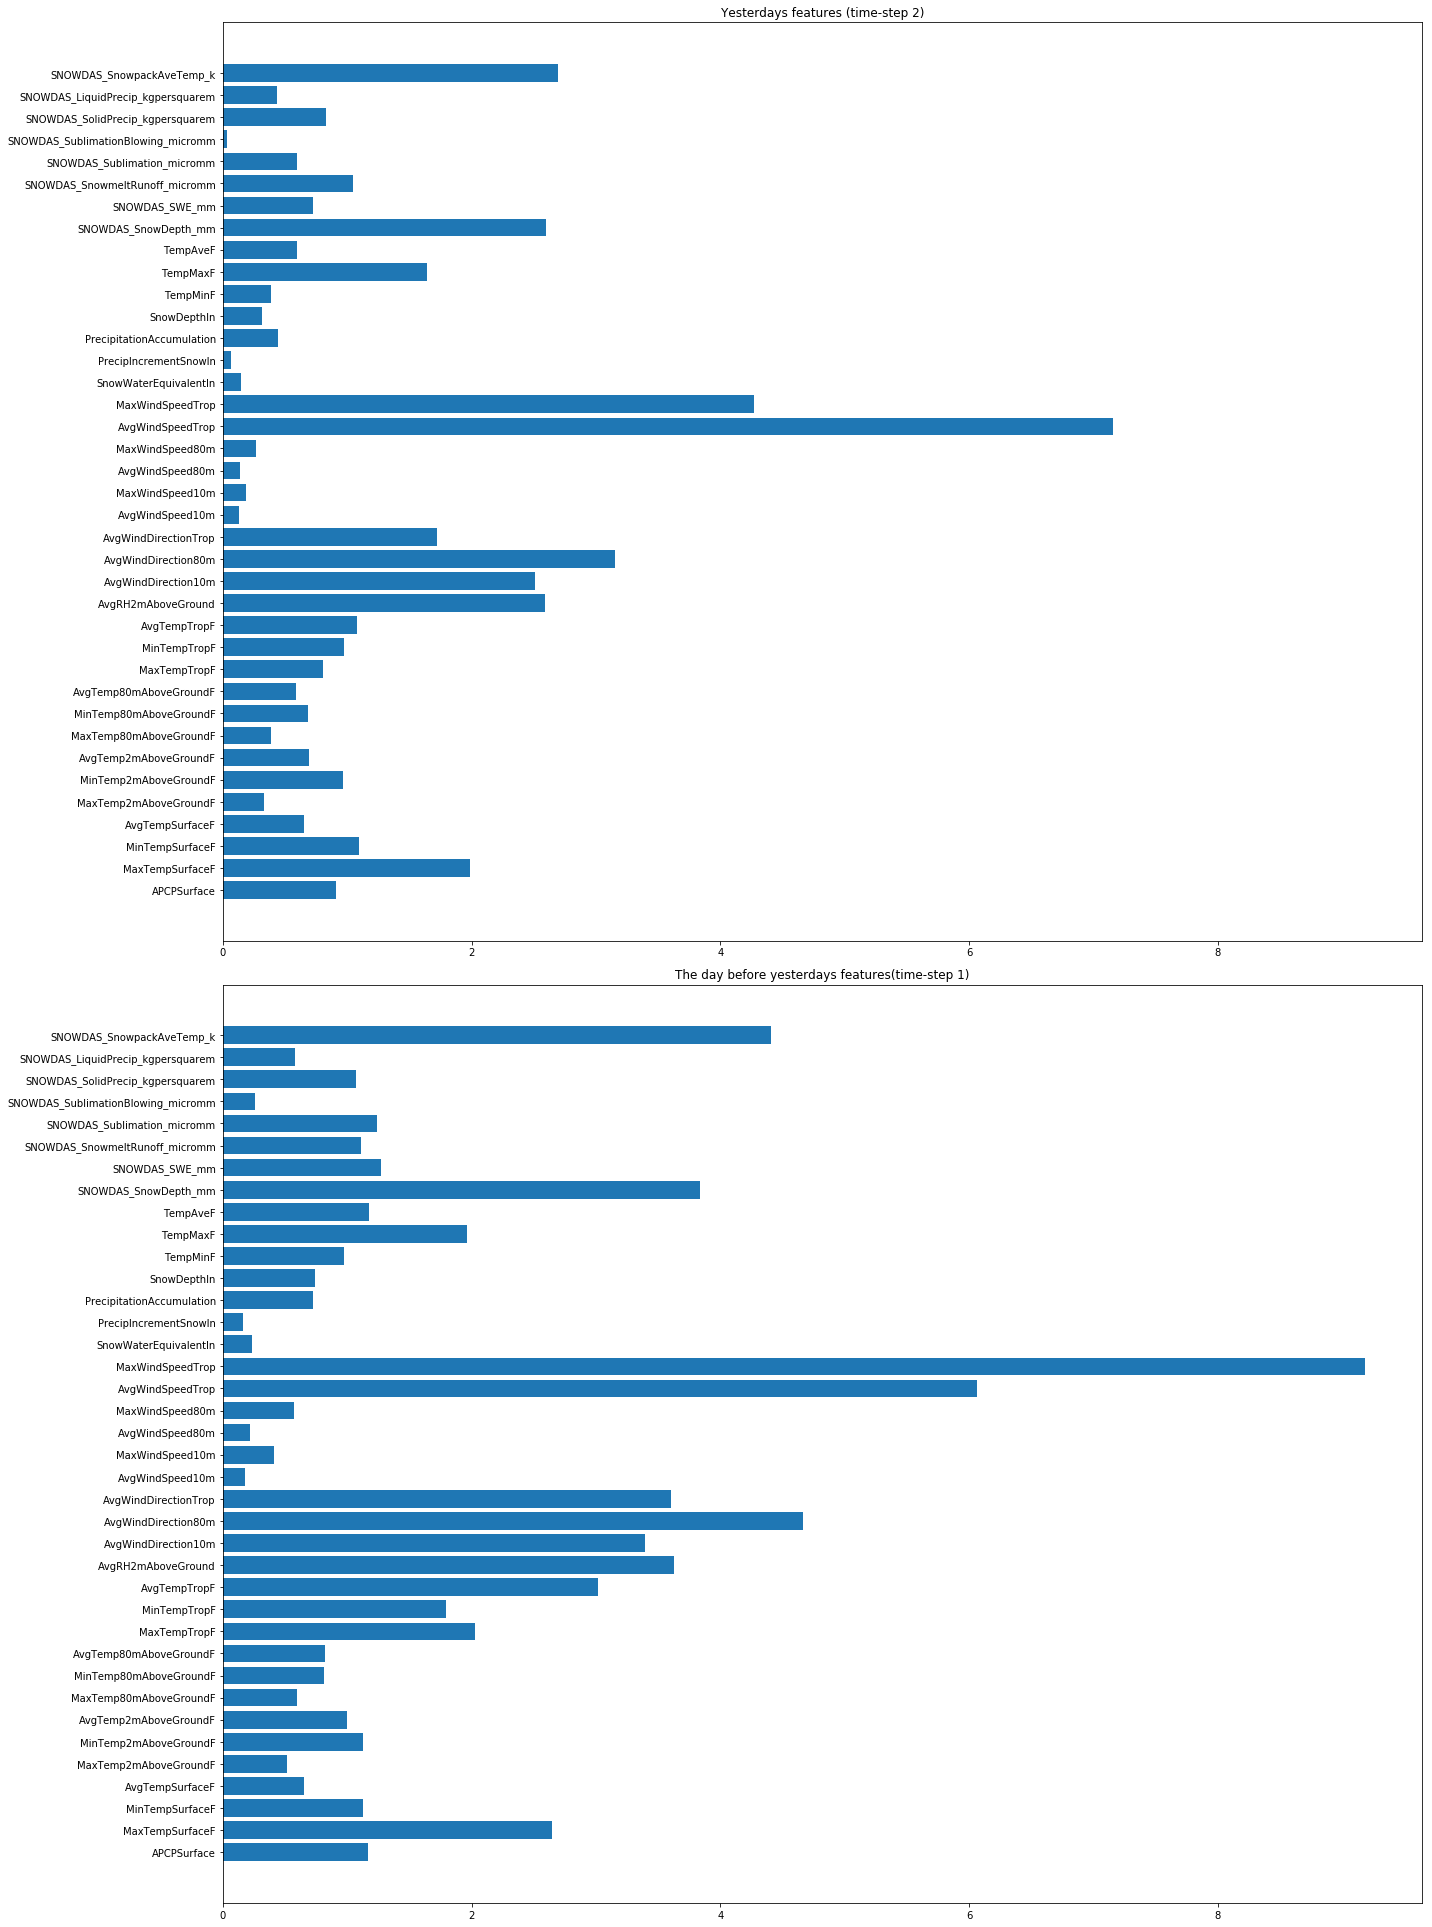

In [30]:
plt.figure(figsize=(20,40))
plt1 = plt.subplot(311)

plt1.barh(x_pos,sum_0[1])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title('Yesterdays features (time-step 2)')
plt2 = plt.subplot(312,sharex=plt1)
plt2.barh(x_pos,sum_0[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title('The day before yesterdays features(time-step 1)')
plt.tight_layout()

plt.show()

In [31]:
shap_val_3 = shape_val
shap_val_3 = np.array(shap_val_3)
shap_val_3 = np.reshape(shap_val_3[3],(int(shap_val_3.shape[1]),int(shap_val_3.shape[2]),int(shap_val_3.shape[3])))
shap_abs_3 = np.absolute(shap_val_3)
sum_3 = np.sum(shap_abs_3,axis=0)

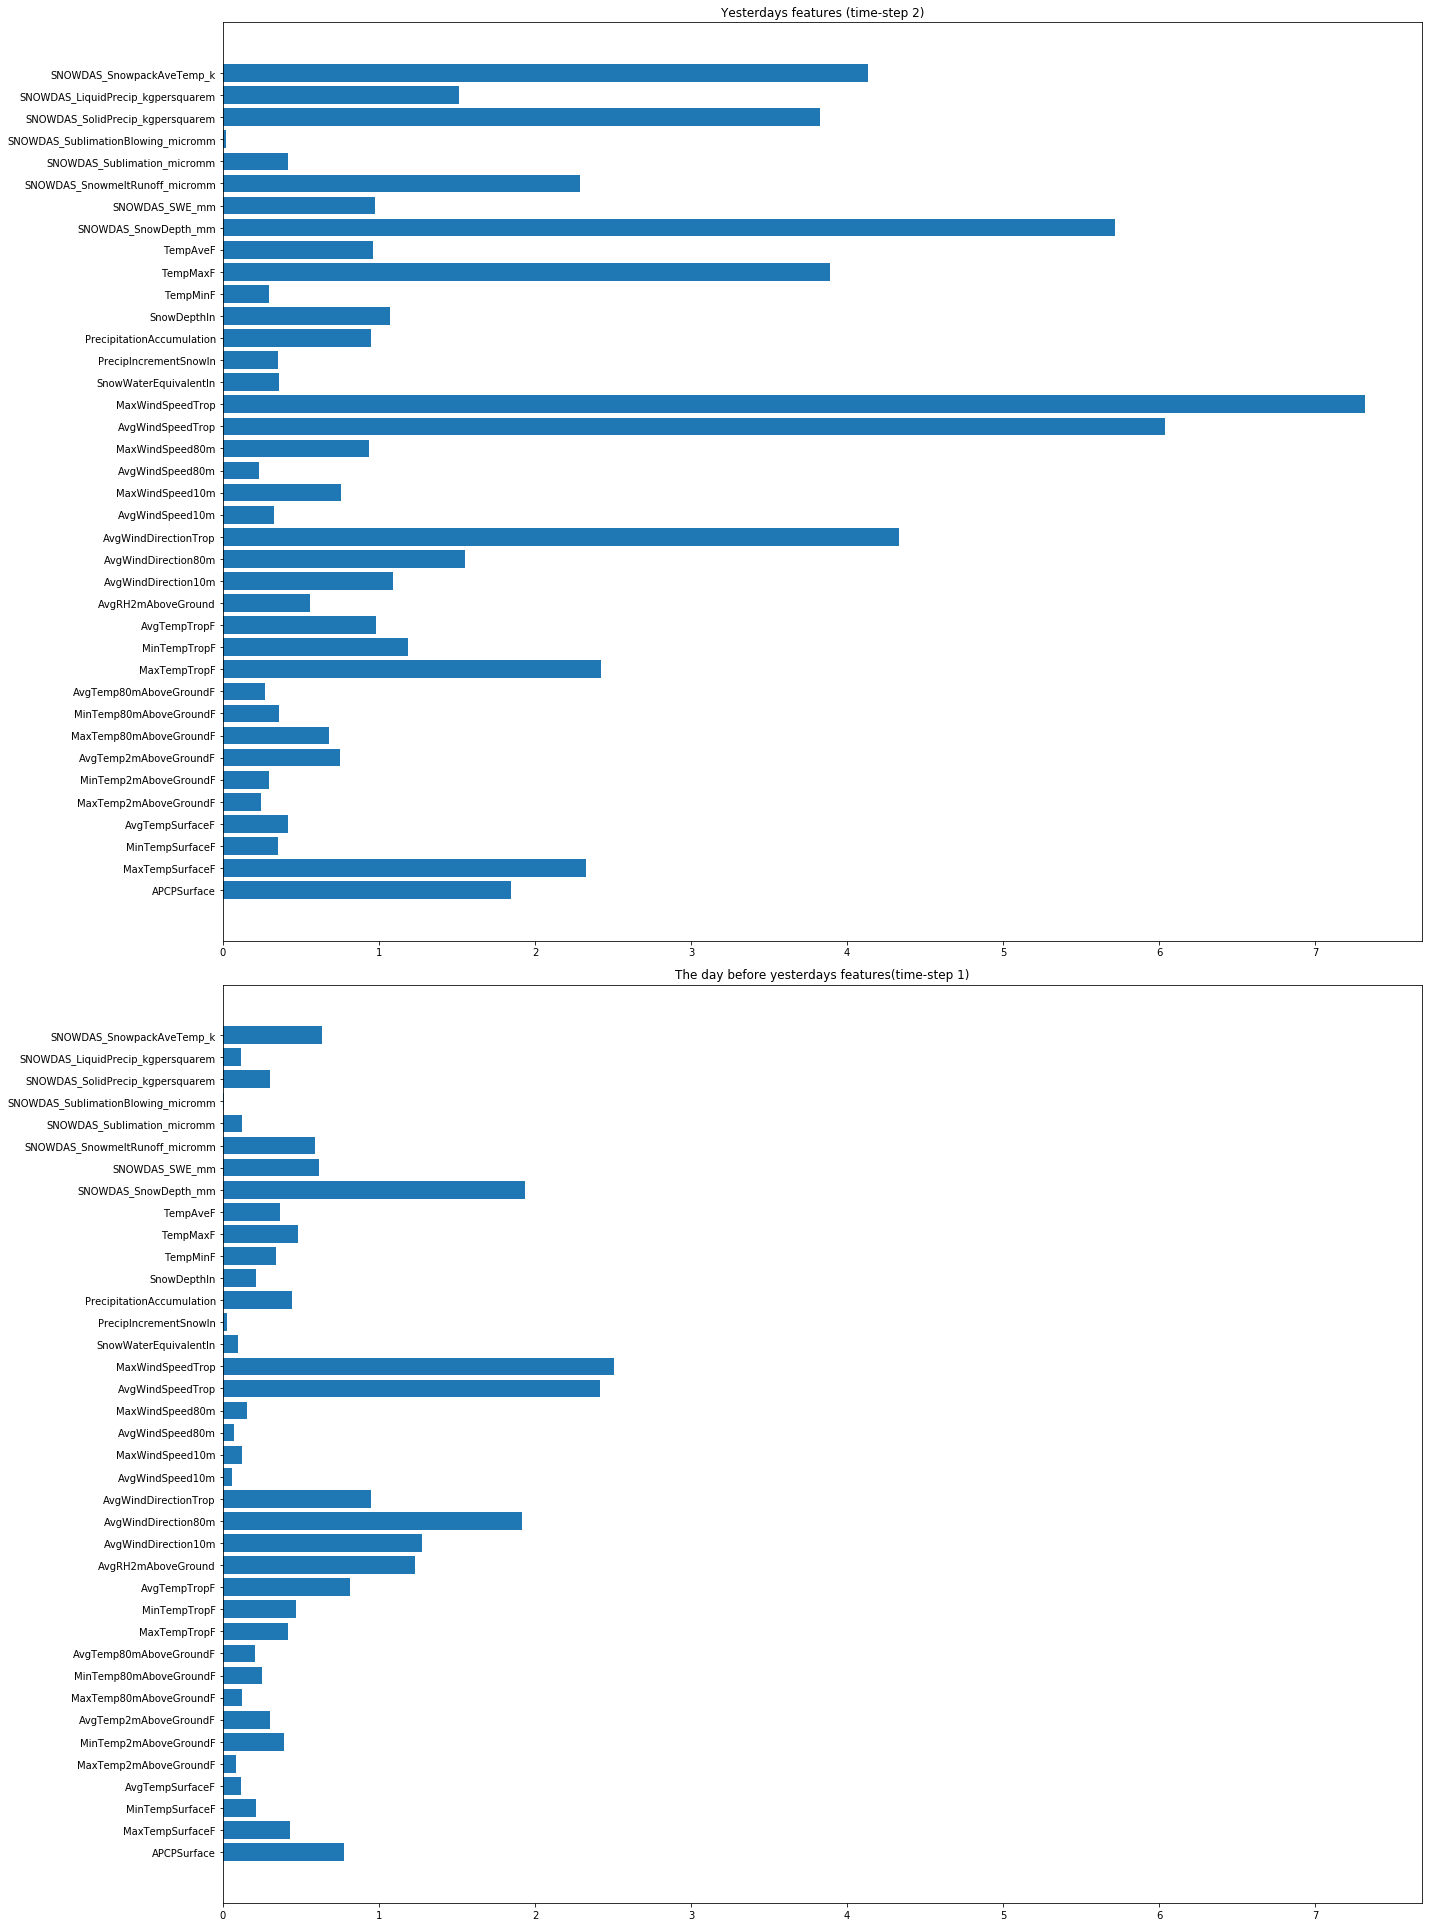

In [32]:
plt.figure(figsize=(20,40))
plt1 = plt.subplot(311)

plt1.barh(x_pos,sum_3[120])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title('Yesterdays features (time-step 2)')
plt2 = plt.subplot(312,sharex=plt1)
plt2.barh(x_pos,sum_3[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title('The day before yesterdays features(time-step 1)')
plt.tight_layout()

plt.show()

In [ ]:
run.log_image(name='Low Feature Importances4', plot=f1)

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

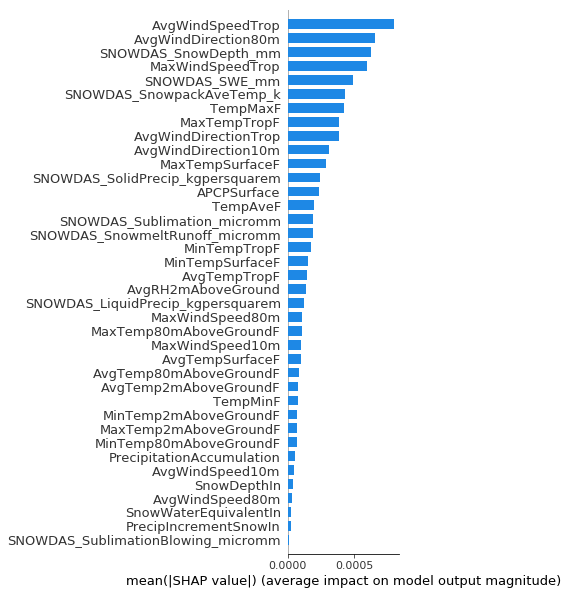

In [33]:
f1 = plt.figure(figsize=(2,10))


shap.summary_plot(shap_val[3], feature_names=f_names, max_display=42, plot_type='bar', auto_size_plot=False)


In [ ]:
shap.summary_plot(shap_val[3], feature_names=f_names, max_display=42, plot_type='bar', auto_size_plot=False)

In [ ]:
shap.dependence_plot(ind=0, shap_values=shap_val[3], feature_names=f_names, features=shap_test_X[3])

In [ ]:
shap_val[2]

In [ ]:
shap_test_X[0].shape

In [ ]:
shap.force_plot(e.expected_value[0], shap_val[0], shap_test_X[1], feature_names=f_names)

In [ ]:
shap.initjs()

In [ ]:
e.expected_value.shape